In [1]:
import torch
import matplotlib.pyplot as plt
from skripsi_program import Burgers, FourierBasis

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    }
)

In [7]:
generator = torch.Generator().manual_seed(42)
problem = Burgers()
u, f = problem.generate(
    basis=FourierBasis, n=200, modes=20, u0="random", f=0, generator=generator
)
u.coeff.isnan().sum()

tensor(0)

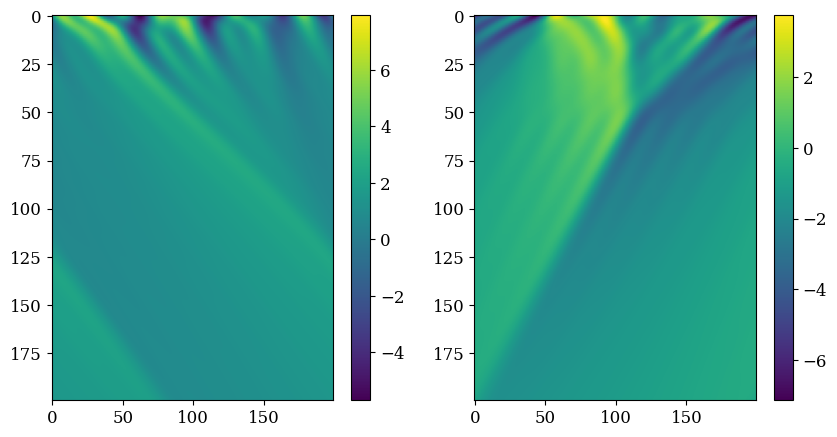

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
u.plot(i=0, aspect="auto")
# plt.legend(["initial condition", "mid condition", "final condition"])
plt.colorbar()
plt.subplot(122)
u.plot(i=1,aspect="auto")
plt.colorbar()

In [10]:
generator = torch.Generator().manual_seed(42)
problem = Burgers()
u, f = problem.generate(
    basis=FourierBasis, n=200, modes=20, u0=0, f="random", generator=generator
)
u.coeff.isnan().sum()

tensor(0)

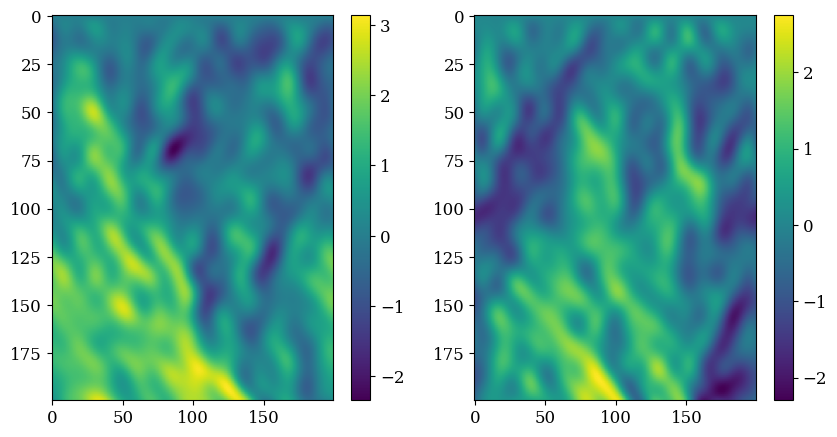

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
u.plot(i=0, aspect="auto")
# plt.legend(["initial condition", "mid condition", "final condition"])
plt.colorbar()
plt.subplot(122)
u.plot(i=1,aspect="auto")
plt.colorbar()

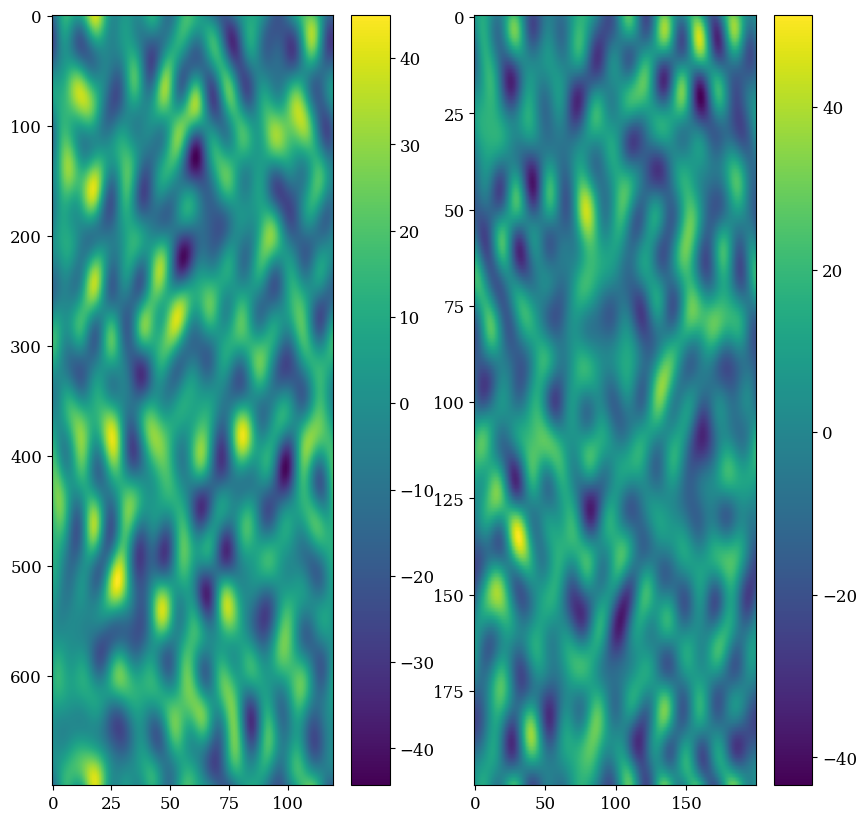

In [13]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
f.plot(res=(slice(0,1,700), slice(0,1,120)), aspect="auto")
# plt.legend(["initial condition", "mid condition", "final condition"])
plt.colorbar()
plt.subplot(122)
f.plot(i=1, aspect="auto")
plt.colorbar()